# Tensorpack GAN with MNIST data
#### programming through these following steps
* **Data Loading** (Dataflow)
* **Build a model**
* **Training & test** (CPU, GPU, or MultiGPU)
* **Trasfer learning** (Loading a saved Model and training it agiain)
* **Evaluation** (Loading a saved Model and test it)


### GAN.py

In [ ]:
# -*- coding: utf-8 -*-
# File: GAN.py
# Author: Yuxin Wu

import tensorflow as tf
import numpy as np
from tensorpack import (TowerTrainer,
                        ModelDescBase, DataFlow, StagingInput)
from tensorpack.tfutils.tower import TowerContext, TowerFuncWrapper
from tensorpack.graph_builder import DataParallelBuilder, LeastLoadedDeviceSetter
from tensorpack.tfutils.summary import add_moving_summary
from tensorpack.utils.argtools import memoized

####
# ModelDescBase class에서 상속받은 내장 함수, build_graph(), inputs(), get_inputs_desc() 를 GANModelDesc class에서 사용할 수 있다. 
####

class GANModelDesc(ModelDescBase):
    def collect_variables(self, g_scope='gen', d_scope='discrim'):
        """
        Assign `self.g_vars` to the parameters under scope `g_scope`,
        and same with `self.d_vars`.
        """
        self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, g_scope)
        assert self.g_vars
        self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, d_scope)
        assert self.d_vars
#         보통 GAN에서 gen, discrim scope의 vars는 optimizer를 정의하고 train step을 정의할때 var_list option의 parameter로 사용된다. 
#         그래서 tf.get_collection()에서도 TRAINABLE_VARIABLES라고 표기 되어있음.
    

        
    def build_losses(self, logits_real, logits_fake):
#         """
#         Build standard GAN loss and set `self.g_loss` and `self.d_loss`.
#         D and G play two-player minimax game with value function V(G,D)
#           min_G max _D V(D, G) = IE_{x ~ p_data} [log D(x)] + IE_{z ~ p_fake} [log (1 - D(G(z)))]
#         Args:
#             logits_real (tf.Tensor): discrim logits from real samples
#             logits_fake (tf.Tensor): discrim logits from fake samples produced by generator
#         """
        with tf.name_scope("GAN_loss"):
            score_real = tf.sigmoid(logits_real)
            score_fake = tf.sigmoid(logits_fake)
            tf.summary.histogram('score-real', score_real)
            tf.summary.histogram('score-fake', score_fake)

            with tf.name_scope("discrim"):
                d_loss_pos = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=logits_real, labels=tf.ones_like(logits_real)), name='loss_real')
                d_loss_neg = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=logits_fake, labels=tf.zeros_like(logits_fake)), name='loss_fake')

                d_pos_acc = tf.reduce_mean(tf.cast(score_real > 0.5, tf.float32), name='accuracy_real')
                d_neg_acc = tf.reduce_mean(tf.cast(score_fake < 0.5, tf.float32), name='accuracy_fake')

                d_accuracy = tf.add(.5 * d_pos_acc, .5 * d_neg_acc, name='accuracy')
                self.d_loss = tf.add(.5 * d_loss_pos, .5 * d_loss_neg, name='loss')

            with tf.name_scope("gen"):
                self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=logits_fake, labels=tf.ones_like(logits_fake)), name='loss')
                g_accuracy = tf.reduce_mean(tf.cast(score_fake > 0.5, tf.float32), name='accuracy')

            add_moving_summary(self.g_loss, self.d_loss, d_accuracy, g_accuracy)

    def build_graph(self, *inputs):
        """
        Have to build one tower and set the following attributes:
        g_loss, d_loss, g_vars, d_vars.
        """
        pass

    @memoized
    def get_optimizer(self):
        return self.optimizer()


class GANTrainer(TowerTrainer):
    def __init__(self, input, model):
        #"""
        #Args:
        #    input (InputSource):
        #    model (GANModelDesc):
        #"""
        super(GANTrainer, self).__init__()
#         assert isinstance(model, GANModelDesc), model # GANModelDesc 에서 정의된 model을 사용하는 것이 맞는지 확인하기 위함.
#         # 여기서 model은 GANModelDesc 에서 정의된 model이다. 근데 어떻게 가지고 온것일까? 아니면 나중에 Trainconfig()에서 training 시킬때 parameter로 GANTrainer(self, input, model)에서 model = GANModelDesc()하는 것일까? 
        assert isinstance(model, Model), model ### ****** checkpoint!!!
        inputs_desc = model.get_inputs_desc() # GANModelDesc or Model 에서 정의된 model의 input list을 가져와 input_desc에 assgin한다.  
        # Setup input
        cbs = input.setup(inputs_desc) # callback 시 필요한 input 데이터 셋업
        self.register_callback(cbs)
        
        #"""
        #We need to set tower_func because it's a TowerTrainer,
        #and only TowerTrainer supports automatic graph creation for inference during training.
        #If we don't care about inference during training, using tower_func is
        #not needed. Just calling model.build_graph directly is OK.
        #"""
        
        # build the graph ### 얘는 GANModelDesc interface로 정의된 model을 
        self.tower_func = TowerFuncWrapper(model.build_graph, inputs_desc) # GANModelDesc 에서 정의된 model의 input list를 사용하여 training할 tower(model) function으로 wrapping한다. 
        with TowerContext('', is_training=True):
            self.tower_func(*input.get_input_tensors()) ## *input 대신에 뭘 넣어줘야하는거 같은데.. 아닌가? 확인해보자!
            #tower_func(*input.get_input_tensors()) : ###
            
        opt = model.get_optimizer() # Model interface의 정의된 optimizer(self) 함수의 d_opt, g_opt를 반환한다.
        # opt : self.optimizer()
        
        # define the training iteration(with using g_vars, d_vars)
        # by default, run one d_min after one g_min
        
        with tf.name_scope('optimize'): # 여기서 opt은 그냥 self.optimizer() 이니까 AdamOptimizer()를 사용해야할거 같은데, d_train_step = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=dvar) 참고
            g_min = opt.minimize(model.g_loss, var_list=model.g_vars, name='g_opt') # Model class에서 정의한 opt을 Adam으로 해주자.
            with tf.control_dependencies([g_min]):
                d_min = opt.minimize(model.d_loss, var_list=model.d_vars, name='d_opt')
        
        self.train_op = d_min

        
class SeparateGANTrainer(TowerTrainer):
    #""" A GAN trainer which runs two optimization ops with a certain ratio."""
    def __init__(self, input, model, d_period=1, g_period=1):
        #"""
        #Args:
        #    d_period(int): period of each d_opt run
        #    g_period(int): period of each g_opt run
        #"""
        super(SeparateGANTrainer, self).__init__() # super : 상위 클래스의 initializing을 중복해서 하지마라, 지금 있는 클래스의 init만 하자.
        self._d_period = int(d_period)
        self._g_period = int(g_period)
        assert min(d_period, g_period) == 1 # assert 다음에 나오는 값이 false면 error 발생, 이걸 확인해주기 위해 assert를 써준다. 어디서 에러가 발생했는지 알기 위해서, debug를 잘 하기 위해 사용하는 방법
        
        # setup input
        cbs = input.setup(model.get_inputs_desc())
        self.register_callback(cbs)
        
        # build the graph
        self.tower_func = TowerFuncWrapper(model.build_graph, model.get_inputs_desc())
        with TowerContext('', is_training=True):
            self.tower_func(*input.get_input_tensors())
            
        opt = model.get_optimizer()
        with tf.name_scope('optimize'):
            self.d_min = opt.minimize(
                model.d_loss, var_list=model.d_vars, name='d_min')
            self.g_min = opt.minimize(
                model.g_loss, var_list=model.g_vars, name='g_min')
            
    def run_step(self):
        # define the training iteration
        if self.global_step % (self._d_period) == 0:
            self.hooked_sess.run(self.d_min)
        if self.global_step % (self._g_period) == 0:
            self.hooked_sess.run(self.g_min)
            

class MultiGPUGANTrainer(TowerTrainer):
    #"""
    #A replacement of GANTrainer (optimize d and g one by one) with multi-gpu support.
    #"""
    def __init__(self, num_gpu, input, model):
        super(MultiGPUGANTrainer, self).__init__()
        assert num_gpu > 1
        raw_devices = ['/gpu;{}'.format(k) for k in range(num_gpu)]
        
        # setup input
        input = StagingInput(input)
        cbs = input.setup(model.get_inputs_desc())
        self.register_callback(cbs)
        
        # build the graph with multi-gpu replication
        def get_cost(*inputs):
            model.build_graph(*inputs)
            return [model.d_loss, model.g_loss]
        
        self.tower_func = TowerFuncWrapper(get_cost, model.get_inputs_desc())
        devices = [LeastLoadedDeviceSetter(d, raw_devices) for d in raw_devices]
        cost_list = DataParallelBuilder.build_on_towers(
            list(range(num_gpu)),
            lambda: self.tower_func(*input.get_input_tensors()),
            devices)
        # simply average the cost here. It might be faster to average the gardients
        with tf.name_scope('optimize'):
            d_loss = tf.add_n([x[0] for x in cost_list]) * (1.0 / num_gpu)
            g_loss = tf.add_n([x[1] for x in cost_list]) * (1.0 / num_gpu)

            opt = model.get_optimizer()
            # run one d_min after one g_min
            g_min = opt.minimize(g_loss, var_list=model.g_vars,
                                    colocate_gradients_with_ops=True, name='g_opt')
            with tf.control_dependencies([g_min]):
                d_min = opt.minimize(d_loss, var_list=model.d_vars,
                                        colocate_gradients_with_ops=True, name='d_opt')
            
            # define the training iteration
            self.train_op = d_min
            
class RandomZData(DataFlow):
       def __init__(self, shape):
            super(RandomZData, self).__init__()
            self.shape = shape
       
       def get_data(self):
            while True:
                yield [np.random.uniform(-1, 1, size=self.shape)]


In [2]:
# -*- coding: utf-8 -*-

import cv2 # for using AugmentImageComponent
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from GAN import *
from PIL import Image
from tensorpack import *
from tensorpack.dataflow import *
from tensorpack.callbacks import *
from tensorpack.tfutils import summary
from tensorpack.utils.viz import stack_patches
from tensorpack.tfutils.scope_utils import auto_reuse_variable_scope

## 1. Get DataFlow
### load mnist dataset

In [3]:
def get_dataflow(batch_size, is_train='train'): # str type
    # bool_is_train = is_train == 'train' : 우리는 T/F로 코딩을 하는 경우가 많다. 
    df = dataset.Mnist(is_train, shuffle=True) # return type: dataflow(df)
    # dataset에 있는 Mnist data를 가지고 온다. FashionMnist Data도 있다. 
    # ----- Image Augmentation Options -------- #
    if is_train is 'train':
        augs = [
            #   imgaug.CenterCrop(256, 256),
            #   imgaug.Resize((225, 225)),
            #   imgaug.Grayscale(keepdims=True),
#                imgaug.Flip(horiz=True, vert=False, prob=0.5),
        ]
    else:
        augs = [
            #   imgaug.CenterCrop(256, 256),
            #   imgaug.Resize((225, 225)),
        ]
    df = AugmentImageComponent(df, augs)
    # group data into batches of size 128
    df = BatchData(df, batch_size)
    # start 3 processes to run the dataflow in parallel
    # df = PrefetchDataZMQ(df, 10, multiprocessing.cpu_count())
    # df = PrefetchDataZMQ(df, 64) # : batch size = 64
    return df

### See the data

[0823 23:52:53 @fs.py:100] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.


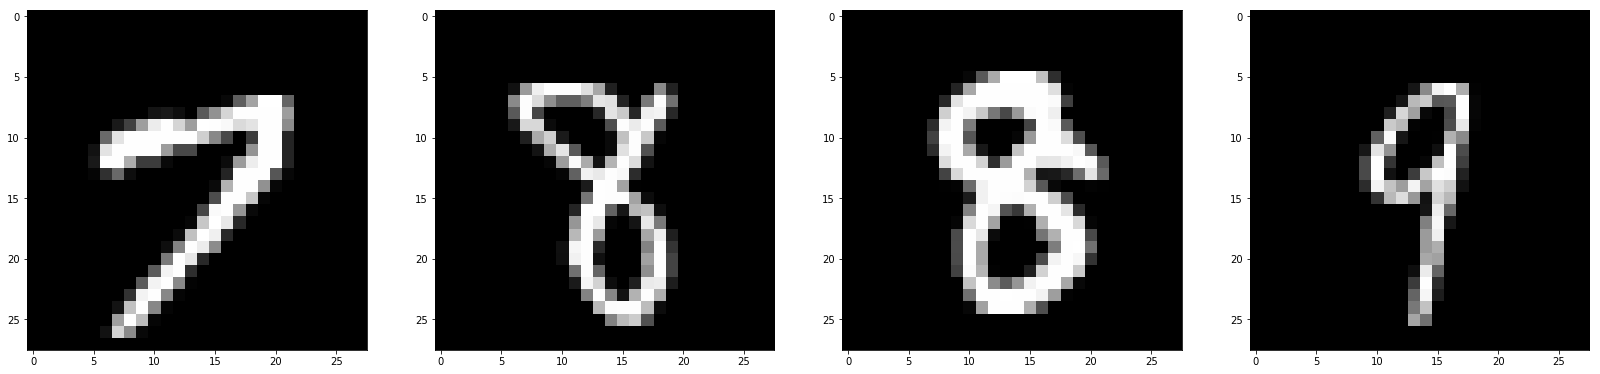

In [4]:
df = get_dataflow(4, 'train') #(batch_size, )
df.reset_state() # 보통 안해줘도 된다. 

fig =plt.figure(figsize=(28, 28))

for idx, dp in enumerate(df.get_data()):
    if idx == 0:
        for i in range(4):
            img = dp[idx][i]
            fig.add_subplot(1, 4, i + 1)
            plt.imshow(img, cmap='gray')
        plt.show()
    break

## 2. Model 
#### Model includes Loss function & Optimizer

In [14]:
class Model(GANModelDesc):
#     # hyperparameter 설정
#         num_epoch = 100000 # 에폭 수가 크면 로컬 보다는 GPU로, Training 단계에서 설정, main.py -  
#         batch_size = 64 # Training 단계에서 설정, main.py - 
    def __init__(self, num_input, num_latent_variable, num_hidden, batch, learning_rate):
        self.NumInput = num_input
        self.NumLatentVariable = num_latent_variable
        self.NumHidden = num_hidden
        self.batch = batch
        self.LearningRate = learning_rate
        
#     global num_input 
#     global num_latent_variable 
#     global num_hidden 
#     global learning_rate
        
    def inputs(self):
        """
        Define input shape, MNIST data
        """
        return [tf.placeholder(tf.float32, [None, self.NumInput], 'X')] # input image size
                 
        
    # Generator 생성하는 함수 정의 
    # Inputs: 
    #     Z : input Latent Variable (noise variable)
    # Output:
    #    generated_mnist_image : Generator로부터  생성된 MNIST 이미지
    def build_generator(self, Z): # inputs() 에서 반환될 리스트 중 2번째 요소 Z가 들어와야함
        # Generator 함수에서 사용되는 변수들 설정
        # 100 -> 128 -> 784 : layer 통과 할 때마다 image 개수 num_input 수에 맞추기.
        with tf.variable_scope('generator'):
            # hidden layer paremeter
            G_W1 = tf.Variable(tf.random_normal(shape=[self.NumLatentVariable, self.NumHidden], stddev=5e-2))
            G_b1 = tf.Variable(tf.constant(0.1, shape=[self.NumHidden]))
            # output layer parameter
            G_W2 = tf.Variable(tf.random_normal(shape=[self.NumHidden, self.NumInput], stddev=5e-2))
            G_b2 = tf.Variable(tf.constant(0.1, shape=[self.NumInput]))
            
            hidden_layer = tf.nn.relu((tf.matmul(Z, G_W1) + G_b1))
            output_layer = tf.matmul(hidden_layer, G_W2) + G_b2
            generated_mnist_image = tf.nn.sigmoid(output_layer)
    
        return generated_mnist_image # 생성된 이미지 반환.

    # Discriminator를 생성하는 함수를 정의
    # Inputs:
    #   X : 인풋 이미지
    # Output:
    #   predicted_value : Discriminator가 판단한 True(1) or Fake(0)
    #   logits : sigmoid를 씌우기전의 출력값
    def build_discriminator(self, X):
        # Discriminator 함수에서 사용되는 변수들 설정 
        # 784 -> 128 -> 1 : Generator에서 생성된 784 image 들을 1개로 만들어 인풋 이미지와 구별
        with tf.variable_scope('discriminator'):
            # hidden layer parameter
            D_W1 = tf.Variable(tf.random_normal(shape=[self.NumInput, self.NumHidden], stddev=5e-2))
            D_b1 = tf.Variable(tf.constant(0.1, shape=[self.NumHidden]))
            # output layer parameter
            D_W2 = tf.Variable(tf.random_normal(shape=[self.NumHidden, 1], stddev=5e-2))
            D_b2 = tf.Variable(tf.constant(0.1, shape=[1]))
            hidden_layer = tf.nn.relu((tf.matmul(X, D_W1) + D_b1))
            logits = tf.matmul(hidden_layer, D_W2) + D_b2
            predicted_value = tf.nn.sigmoid(logits)
        
        return logits
    
    
    
    
    def build_graph(self, X): # mapping input data automatically
        # build a cost_func (loss function) -> build_losses(), need logits_real, fake.
        # collect_variables(self, g_scope='gen', d_scope='discrim')
        # build_losses(self, logits_real, logits_fake)
        
        #Z = tf.random_uniform([self.batch, self.NumLatentVariable], -1, 1,  'Z_train')
        Z = tf.random_uniform([self.batch, self.NumLatentVariable], -1, 1, name='Z_train')
        Z = tf.placeholder_with_default(Z, [None, self.NumLatentVariable], name='Z')
            
            

        with tf.variable_scope('Gen'):
            gen_image = self.build_generator(Z)
        tf.summary.image('Generated_image', gen_image, max_outputs=25)
            
        with tf.variable_scope('Discrim'):
            
            logits_real = self.build_discriminator(X)
            logits_fake = self.build_discriminator(gen_image)   
        
        self.build_losses(logits_real, logits_fake)
        self.collect_variables() # def collect_variables(self, g_scope='gen', d_scope='discrim'):
        


    
    def optimizer(self): # trainer 에서 opt
        lr = self.LearningRate
        return tf.train.AdamOptimizer(lr)


## 3. main.py

### Main - Dataset

In [12]:
# # for tensorboard 
# logger.set_logger_dir('./GAN_mnist_result')
# # logger.auto_set_dir() : command 창에서 사용, jupyter 에서는 사용불가.

# df = get_dataflow(100, 'train') # get_dataflow(batch_size, is_train='train')
# df_test = get_dataflow(100, 'test')

# df.reset_state()
# df_test.reset_state()

# def get_dataflow(batch_size, is_train='train'):
df = get_dataflow(100, 'train') # batch size : 100  
steps_per_epoch = df.size() # 60000/100, df = BatchData(df, batch_size)

# In Model class 
# def __init__(self, num_input, num_latent_variable, num_hidden, batch, learning_rate):
num_input = 28*28
num_latent_variable = 100 
num_hidden = 128 
batch_size = 64
learning_rate = 0.001

model = Model(num_input, num_latent_variable, num_hidden, batch_size, learning_rate) 



### Main - Training

In [13]:
"""
Configuration containing everything necessary in a training.
"""
config = TrainConfig(
    model = model,
    data = QueueInput(df), # 상황에 따라서 ZMQ사용도 가능, 
    callbacks = [
        # save the model after every epoch
        ModelSaver(),
        
    ],
    steps_per_epoch = steps_per_epoch, # steps_per_epoch = df.size()
    max_epoch = 100000,
)

# training with CPU or GPU?
if tf.test.gpu_device_name():
    logger.set_logger_dir('./GAN_mnist_log')
    MultiGPUGANTrainer(num_gpu = 4,
                      input = QueueInput(df),
                      model = model).train_with_defaults(
                                        callbacks=[PeriodicTrigger(
                                                ModelSaver(checkpoint_dir='./GAN_mnist_result'),
                                                every_k_epochs=10)],
                                        steps_per_epoch = steps_per_epoch,
                                        max_epoch = 100)
else:
    GANTrainer(input = QueueInput(df),
                      model = model).train_with_defaults(
                                        callbacks=[PeriodicTrigger(
                                                ModelSaver(checkpoint_dir='./GAN_mnist_result'),
                                                every_k_epochs=10)],
                                        steps_per_epoch = steps_per_epoch,
                                        max_epoch = 100)

[0824 00:17:44 @logger.py:109] WRN Log directory ./GAN_mnist_log exists! Use 'd' to delete it. 
[0824 00:17:44 @logger.py:112] WRN If you're resuming from a previous run, you can choose to keep it.
Press any other key to exit. 
Select Action: k (keep) / d (delete) / q (quit):d
[0824 00:17:46 @logger.py:74] Argv: /opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-c5ac2c97-d36f-4d6c-b99a-22ab56f7d63f.json
[0824 00:17:46 @input_source.py:202] Setting up the queue 'QueueInput_2/input_queue' for CPU prefetching ...
[0824 00:17:46 @training.py:113] Building graph for training tower 0 ...


AssertionError: 

### See the original Images

In [ ]:
origin = get_dataflow(25, 'train')
origin.reset_state()

for idx, dp in enumerate(origin.get_data()):
    if idx == 0:
        dp = dp[0] + 1
        dp = dp * 90.0
        img = stack_patches(dp, nr_row=5, nr_col=5)  
        
        temp = img.reshape(332, 332)
        plt.axis('off')
        plt.imshow(temp, cmap='gray')
        break

### See the generated Images

In [ ]:
model = Model(num_input, num_latent_variable, num_hidden, batch_size, learning_rate)

# loading the saved model.
session = get_model_loader('./GAN_mnist_log/model-60000.index')

pred_config = PredictConfig(
        model = model,
        session_init = session,
        input_names = ['Z'],
        output_names = ['gen/gen', 'Z']
    )

# make 25 images
pred = SimpleDatasetPredictor(pred_config, RandomZData((25, 100)))

for i, gen in enumerate(pred.get_result()):  
    gen = gen[0] + 1
    gen = gen * 90.0
    gen = np.clip(gen, 0, 255)
    gen = gen[:, :, :, ::-1]
    img = stack_patches(gen, nr_row=5, nr_col=5)
    
    temp = img.reshape(332, 332)
    plt.axis('off')
    plt.imshow(temp, cmap='gray')
    break

### Evaluation

In [ ]:
model = Model(num_input, num_latent_variable, num_hidden, batch_size, learning_rate)
session = get_model_loader('./GAN_mnist_result/model-6000.index')

pred_config = PredictConfig(
        model=model,
        session_init=session,
        input_names=['X', 'Z'], # class Model-inputs
        output_names=['accuracy', 'Loss'] # class Model-build_graph
    )
pred = SimpleDatasetPredictor(pred_config, df_test)

In [ ]:
accuracy = 0.0
total_loss = 0.0

for i, (acc, loss) in enumerate(pred.get_result()): # 각 batch마다 pred에서 get_result
    accuracy += acc 
    total_loss += loss
    
print("Accuracy: {:0.3f}".format(accuracy/(i+1)))
print("Loss: {:0.3f}".format(total_loss/(i+1)))